**Please run the `animate.py` file directly for smoother animations.**

____

# Importing Libraries

In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# for binding arguments to functions
from functools import partial

____

# Initialize animation functions

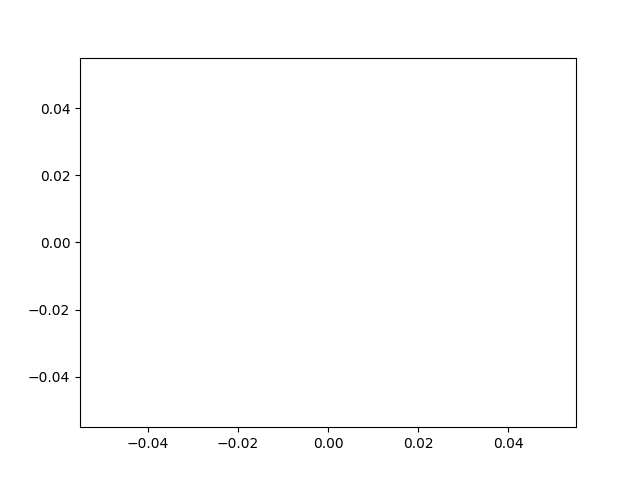

In [2]:
fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = ax.plot([], [], 'r')

def init(xlim_1, ylim_1, xlim_2, ylim_2):
    """
    Initialize axes for plotting by setting X and Y limits
    """
    ax.set_xlim(xlim_1, xlim_2)
    ax.set_ylim(ylim_1, ylim_2)
    return ln,

____

# Simple morphing

The given example appears to be a series of polygons inscribed in the unit circle, with one of the vertices at $(1, 0)$. We can interpolate these polygons in 2D space by parameterizing points based on length.

First, we create a function that generates a polygon between a given list of vertices:

In [3]:
def genpoly(vertices, n):
    """
    Generate a polygon with `n` points using the co-ordinates given, and return
    the points in it.
    """
    
    # lists of vertices to concatenate
    lists = []
    
    n_vert = vertices.shape[0]
    points_per_vertex = n // n_vert # this need not necessarily divide n evenly
    
    t = np.linspace(0, 1, points_per_vertex + 1)[:-1]
    ones = np.ones(points_per_vertex)
    
    for i in range(n_vert - 1):
        lists.append(np.column_stack(
            [
                # lerp between vertices
                t * vertices[i + 1][j] + (ones - t) * vertices[i][j]
                for j in [0, 1]
            ]
        ))
        
    # put all the leftover points in the final edge
    t = np.linspace(0, 1, n - points_per_vertex * (n_vert - 1))
    ones = np.ones(n - points_per_vertex * (n_vert - 1))
    
    lists.append(np.column_stack(
        [
            t * vertices[0][j] + (ones - t) * vertices[n_vert - 1][j]
            for j in [0, 1]
        ]
    ))

    return np.concatenate(lists)

Now, we set some configuration:

In [4]:
total_frames = 800
polygon_points = 840
low_poly = 3
high_poly = 8
num_pause = 2

Next we define the update function for each frame:

In [5]:
def update(polygons, num_pause, frame):
    """
    Linear interpolate between polygons. Pause for `num_pause` between the
    forward and backward animations.
    """
    i = int(np.floor(frame))

    # lists of points to interpolate between
    x1 = None
    x2 = None
    y1 = None
    y2 = None
    
    num_poly = len(polygons)

    if i < num_poly - 1:
        # forward animation
        x1 = polygons[i][:, 0]
        y1 = polygons[i][:, 1]

        x2 = polygons[i + 1][:, 0]
        y2 = polygons[i + 1][:, 1]

    elif i < num_poly - 1 + num_pause:
        last = polygons[-1]
        ln.set_data(last[:, 0], last[:, 1])

        # pause
        return ln,

    elif i < 2 * num_poly - 2 + num_pause:
        j = 2 * num_poly - 2 + num_pause - i
        
        # backward animation
        x1 = polygons[j][:, 0]
        y1 = polygons[j][:, 1]

        x2 = polygons[j - 1][:, 0]
        y2 = polygons[j - 1][:, 1]

    else:
        # pause again
        return ln,

    j = frame - i

    xdata, ydata = x2 * j + x1 * (1 - j), y2 * j + y1 * (1 - j)
    ln.set_data(xdata, ydata)
    return ln,

Now, we create a list of polygons:

In [6]:
polygons = []

for i in range(low_poly, high_poly + 1):
    # add a regular polygon to the list of polygons
    points = 2 * np.pi * np.arange(0, i) / i

    polygons.append(genpoly(
        np.column_stack([
            np.cos(points),
            np.sin(points)
        ]),
        polygon_points
    ))

Now we call the animation function:

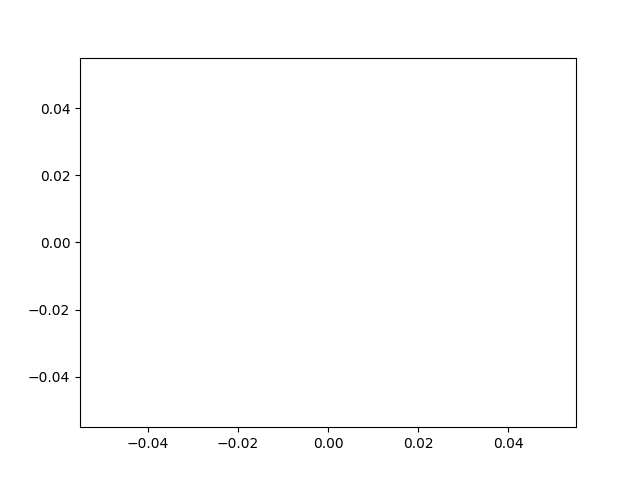

In [7]:
ani = FuncAnimation(fig,
                    partial(update, polygons, 2),
                    frames=np.linspace(0, 2 * (high_poly - low_poly +
                                               num_pause),
                                       total_frames)[:-1],
                    init_func=partial(init, -1.5, -1.5, 1.5, 1.5),
                    blit=True,
                    interval=5,
                    repeat=True)
plt.show()

____

# Given animation
In the given animation, vertices split into two and merge with a vertex in the next polygon.

We create a function that gives us the vertices of the intermediate polygon.

In [3]:
def get_intermediate_vertices(vert1, vert2, step):
    """
    Create an intermediate list of vertices between vert1 and vert2
    by doubling the number of vertices in vert1 and lerping them
    between vert1 and adjacent points in vert2
    """
    new_verts = []

    for i in range(len(vert1)):
        # add one point moving backwards
        new_verts.append(
            np.array([
                step * vert2[i][j] + (1 - step) * vert1[i][j]
                for j in [0, 1]
            ])
        )

        # add one point moving forwards
        new_verts.append(
            np.array([
                step * vert2[i + 1][j] + (1 - step) * vert1[i][j]
                for j in [0, 1]
            ])
        )

    return np.array(new_verts)

Now we set some configuration:

In [4]:
total_frames = 1600
low_poly = 3
high_poly = 8
num_pause = 2

Next we define the update function that draws the intermediate polygons based on the time elapsed:

In [5]:
def update(polygons, num_pause, frame):
    """
    Create intermediate polygons by splitting points.

    num_pause is the amount of time paused between forward/backward cycles
    """
    i = int(np.floor(frame))
    num_poly = len(polygons)

    if i < num_poly - 1:
        # forward animation
        vert = get_intermediate_vertices(polygons[i], polygons[i + 1], frame
                                         - i)

    elif i < num_poly + num_pause - 1:
        vert = polygons[num_poly - 1]

    elif i < 2 * num_poly + num_pause - 2:
        # forward animation
        j = 2 * num_poly - i + num_pause - 2
        
        vert = get_intermediate_vertices(polygons[j - 1], polygons[j], 1 -
                                         (frame - i))

    else:
        # pause again
        vert = polygons[0]

    vert = np.concatenate([vert, [vert[0]]])
    ln.set_data(vert[:, 0], vert[:, 1])
    return ln,


Now, we create a list of polygon vertices:

In [6]:
polygons = []

for i in range(low_poly, high_poly + 1):
    # add a regular polygon to the list of polygons
    points = 2 * np.pi * np.arange(0, i) / i

    polygons.append(
        np.column_stack([
            np.cos(points),
            np.sin(points)
        ])
    )

Now we call the animation function:

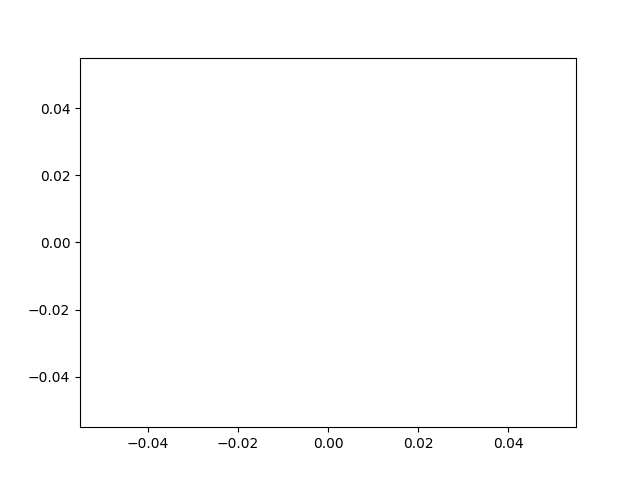

In [7]:
ani = FuncAnimation(fig,
                    partial(update, polygons, num_pause),
                    frames=np.linspace(0, 2 * (high_poly - low_poly +
                                               num_pause),
                                       total_frames),
                    init_func=partial(init, -1.5, -1.5, 1.5, 1.5),
                    blit=True,
                    interval=5,
                    repeat=True)
plt.show()

This method is faster since we do not need to generate the polygon points ourselves and interpolate between every single point in it -- we only interpolate the vertices, and the polygon is drawn between these vertices. The disadvantage of this method is that it only works with polygons.